In [36]:
# !pip install spacy[transformers]==3.3.1

In [38]:
# !pip install spacy-transformers

In [39]:
# !pip install https://huggingface.co/hsengiv/en_gram_core_web_trf/resolve/main/en_gram_core_web_trf-any-py3-none-any.whl

# **Import Necessary Packages**

In [4]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.pipeline.tagger import DEFAULT_TAGGER_MODEL

import spacy_transformers
import en_gram_core_web_trf

from string import punctuation
from collections import Counter

#for plotting images & adjusting colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# **Loaded Spacy Pre-trained Model - Small Model**

In [5]:
nlp = spacy.load('en_core_web_sm')

/usr/local/lib/python3.10/dist-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


# **Method to extract keywords**

1. Extract tokens that are not in STOPWORDS, PUNCTUATIONS
2. Using Counter library for finding the frequency of the terms in the article
3. Finding the most common, top 5 words
4. Normalizing the frequency of keywords with the High frequency keyword
5. Some rules for grammatically correct topic
    1. PROPN - compound
    2. PROPN - root
    3. PROPN - nsubj
    4. VERB - ROOT
    5. NOUN - root
    6. NOUN - amod



In [56]:
def find_topic_from_corpus(corpus, i=0):
  possible_topics = {}
  doc = nlp(corpus)
  print("-------- Doc : ", (i+1), "-------- Length of Doc : ", len(doc), "--------")
  keywords = []
  stopwords = list(STOP_WORDS)
  pos_tag = ['PROPN', 'NOUN', 'VERB', 'ADJ']

  # extracting only terms that is PROPN, NOUN, VERB
  for token in doc:
    if (token.text in stopwords or token.text in punctuation):
      continue
    if (token.pos_ in pos_tag):
      keywords.append(token.text)
  print("Len of keywords", len(keywords))
  
  # Using Counter to find the frequency of the terms
  freq_word = Counter(keywords)
  freq_word.most_common(5)

  #create the wordcloud object
  wordcloud = WordCloud(stopwords = STOPWORDS, collocations=True).generate(" ".join(freq_word.keys()))
  #plot the wordcloud object
  plt.imshow(wordcloud, interpolation='bilInear')
  plt.axis('off')
  plt.show()
  print("Frequent Words")
  print(freq_word.keys())

  # Normalization
  max_freq = Counter(keywords).most_common(1)[0][1]
  for word in freq_word.keys():
    freq_word[word] = (freq_word[word]/max_freq)
  freq_word.most_common(10)

  topics = " ".join([word for word in  freq_word.keys() if (freq_word[word] > 0.5)])
  possible_topics["possible_k"] = []

  topicdoc =  nlp(topics)
  for token in topicdoc:

    # # Approach 1
    # if token.pos_ == "PROPN" and token.dep_ in ["compound", "ROOT", "nsubj"]:
    #   print(token.text, token.pos_)
    #   possible_topics["possible_k"].append([token.text, token.pos_, token.dep_])
    # elif token.pos_ == "VERB" and token.dep_ in ["ROOT"]:
    #   print(token.text, token.pos_)
    #   possible_topics["possible_k"].append([token.text, token.pos_, token.dep_])
    # elif token.pos_ == "NOUN" and token.dep_ in ["ROOT", "amod"]:
    #   print(token.text, token.pos_)
    #   possible_topics["possible_k"].append([token.text, token.pos_, token.dep_])
    
    # Approach 2
    if token.pos_ == "PROPN":
      possible_topics["possible_k"].append([token.text, token.pos_, token.dep_])
    else:
      possible_topics["possible_k"].append([token.text, token.pos_, token.dep_])

    # Combining those keywords as a sentence
    possible_topics['possible_s'] = " ".join([t[0] for t in possible_topics['possible_k']])

  i += 1
  return possible_topics

# **Using en_gram_core_web_trf for grammatical checking of the topic**

In [57]:
import en_gram_core_web_trf
grammar = spacy.load("en_gram_core_web_trf")

In [58]:
def generate_topic(article_sample):
  generated_topics = find_topic_from_corpus(article_sample)
  print("########## Possible Keywords Extracted ##########")
  print(generated_topics)
  print(generated_topics["possible_k"])

  print("########## TOPIC ANALYSIS ##########")
  doc = grammar("START "+generated_topics['possible_s'])
  final_topic = ""
  for token in doc:
    print(token.text, token.tag_)
    if "KEEP" in token.tag_:
      final_topic += " " + token.text
    if "APPEND" in token.tag_:
      final_topic += " " + token.text
      tag_split = token.tag_.split("_")
      if tag_split[1] not in punctuation:
          final_topic += " " + tag_split[1]
    if "REPLACE" in token.tag_:
      tag_split = token.tag_.split("_")
      if tag_split[1] not in punctuation:
        final_topic += " " + tag_split[1]
  print("########## FINAL TOPIC ##########")
  print("***", final_topic.strip(), " END***")  

# **Experimenting the Approach on some sample texts**

**Article related to : Thermodynamics**

-------- Doc :  1 -------- Length of Doc :  646 --------
Len of keywords 272


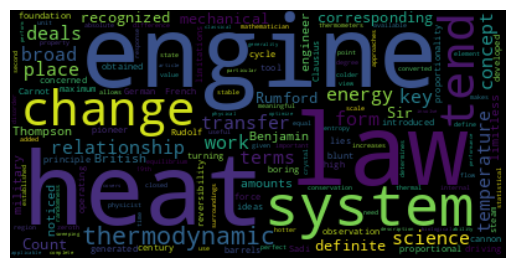

Frequent Words
dict_keys(['thermodynamics', 'science', 'relationship', 'heat', 'work', 'temperature', 'energy', 'broad', 'terms', 'deals', 'transfer', 'place', 'form', 'key', 'concept', 'corresponding', 'definite', 'mechanical', 'Heat', 'recognized', 'Count', 'Rumford', 'Sir', 'Benjamin', 'Thompson', 'British', 'military', 'engineer', 'noticed', 'limitless', 'amounts', 'generated', 'boring', 'cannon', 'barrels', 'proportional', 'turning', 'blunt', 'tool', 'observation', 'proportionality', 'lies', 'foundation', 'pioneer', 'French', 'Sadi', 'Carnot', 'introduced', 'engine', 'cycle', 'principle', 'reversibility', 'concerned', 'limitations', 'maximum', 'obtained', 'steam', 'operating', 'high', 'driving', 'force', 'century', 'ideas', 'developed', 'Rudolf', 'Clausius', 'German', 'mathematician', 'physicist', 'second', 'laws', 'important', 'zeroth', 'law', 'systems', 'thermal', 'equilibrium', 'system', 'property', 'makes', 'meaningful', 'use', 'thermometers', 'define', 'scale', 'conservation'

In [59]:
article_sample  = '''
thermodynamics, science of the relationship between heat, work, temperature, and energy. In broad terms, thermodynamics deals with the transfer of energy from one place to another and from one form to another. The key concept is that heat is a form of energy corresponding to a definite amount of mechanical work.
Heat was not formally recognized as a form of energy until about 1798, when Count Rumford (Sir Benjamin Thompson), a British military engineer, noticed that limitless amounts of heat could be generated in the boring of cannon barrels and that the amount of heat generated is proportional to the work done in turning a blunt boring tool. Rumford’s observation of the proportionality between heat generated and work done lies at the foundation of thermodynamics. Another pioneer was the French military engineer Sadi Carnot, who introduced the concept of the heat-engine cycle and the principle of reversibility in 1824. Carnot’s work concerned the limitations on the maximum amount of work that can be obtained from a steam engine operating with a high-temperature heat transfer as its driving force. Later that century, these ideas were developed by Rudolf Clausius, a German mathematician and physicist, into the first and second laws of thermodynamics, respectively.
The most important laws of thermodynamics are:
The zeroth law of thermodynamics. When two systems are each in thermal equilibrium with a third system, the first two systems are in thermal equilibrium with each other. This property makes it meaningful to use thermometers as the “third system” and to define a temperature scale.
The first law of thermodynamics, or the law of conservation of energy. The change in a system’s internal energy is equal to the difference between heat added to the system from its surroundings and work done by the system on its surroundings.
The second law of thermodynamics. Heat does not flow spontaneously from a colder region to a hotter region, or, equivalently, heat at a given temperature cannot be converted entirely into work. Consequently, the entropy of a closed system, or heat energy per unit temperature, increases over time toward some maximum value. Thus, all closed systems tend toward an equilibrium state in which entropy is at a maximum and no energy is available to do useful work.
The third law of thermodynamics. The entropy of a perfect crystal of an element in its most stable form tends to zero as the temperature approaches absolute zero. This allows an absolute scale for entropy to be established that, from a statistical point of view, determines the degree of randomness or disorder in a system.
Although thermodynamics developed rapidly during the 19th century in response to the need to optimize the performance of steam engines, the sweeping generality of the laws of thermodynamics makes them applicable to all physical and biological systems. In particular, the laws of thermodynamics give a complete description of all changes in the energy state of any system and its ability to perform useful work on its surroundings.
This article covers classical thermodynamics, which does not involve the consideration of individual atoms or molecules. Such concerns are the focus of the branch of thermodynamics known as statistical thermodynamics, or statistical mechanics, which expresses macroscopic thermodynamic properties in terms of the behaviour of individual particles and their interactions. It has its roots in the latter part of the 19th century, when atomic and molecular theories of matter began to be generally accepted.
'''
generate_topic(article_sample)

**Article related to : Artificial Intelligence**

-------- Doc :  1 -------- Length of Doc :  589 --------
Len of keywords 252


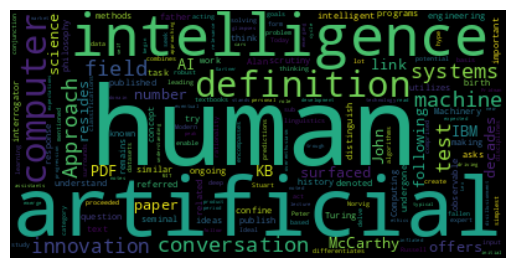

Frequent Words
dict_keys(['number', 'definitions', 'artificial', 'intelligence', 'AI', 'surfaced', 'decades', 'John', 'McCarthy', 'offers', 'following', 'definition', 'paper', 'PDF', 'KB', 'link', 'resides', 'IBM', 'science', 'engineering', 'making', 'intelligent', 'machines', 'computer', 'programs', 'related', 'similar', 'task', 'computers', 'understand', 'human', 'confine', 'methods', 'observable', 'birth', 'conversation', 'denoted', 'Alan', 'Turing', 'seminal', 'work', 'Computing', 'Machinery', 'Intelligence', 'published', 'referred', 'father', 'asks', 'question', 'think', 'test', 'known', 'Test', 'interrogator', 'try', 'distinguish', 'text', 'response', 'undergone', 'scrutiny', 'publish', 'remains', 'important', 'history', 'ongoing', 'concept', 'philosophy', 'utilizes', 'ideas', 'linguistics', 'Stuart', 'Russell', 'Peter', 'Norvig', 'proceeded', 'Artificial', 'Modern', 'Approach', 'leading', 'textbooks', 'study', 'delve', 'potential', 'goals', 'differentiates', 'systems', 'basis', 

In [60]:
article_sample='''
While a number of definitions of artificial intelligence (AI) have surfaced over the last few decades, John McCarthy offers the following definition in this 2004 paper (PDF, 106 KB) (link resides outside IBM), " It is the science and engineering of making intelligent machines, especially intelligent computer programs. It is related to the similar task of using computers to understand human intelligence, but AI does not have to confine itself to methods that are biologically observable."
However, decades before this definition, the birth of the artificial intelligence conversation was denoted by Alan Turing's seminal work, "Computing Machinery and Intelligence" (PDF, 89.8 KB) (link resides outside of IBM), which was published in 1950. In this paper, Turing, often referred to as the "father of computer science", asks the following question, "Can machines think?"  From there, he offers a test, now famously known as the "Turing Test", where a human interrogator would try to distinguish between a computer and human text response. While this test has undergone much scrutiny since its publish, it remains an important part of the history of AI as well as an ongoing concept within philosophy as it utilizes ideas around linguistics.
Stuart Russell and Peter Norvig then proceeded to publish, Artificial Intelligence: A Modern Approach (link resides outside IBM), becoming one of the leading textbooks in the study of AI. In it, they delve into four potential goals or definitions of AI, which differentiates computer systems on the basis of rationality and thinking vs. acting:
Human approach:
Systems that think like humans
Systems that act like humans
Ideal approach:
Systems that think rationally
Systems that act rationally
Alan Turing’s definition would have fallen under the category of “systems that act like humans.”
At its simplest form, artificial intelligence is a field, which combines computer science and robust datasets, to enable problem-solving. It also encompasses sub-fields of machine learning and deep learning, which are frequently mentioned in conjunction with artificial intelligence. These disciplines are comprised of AI algorithms which seek to create expert systems which make predictions or classifications based on input data.
Today, a lot of hype still surrounds AI development, which is expected of any new emerging technology in the market. As noted in Gartner’s hype cycle (link resides outside IBM), product innovations like, self-driving cars and personal assistants, follow “a typical progression of innovation, from overenthusiasm through a period of disillusionment to an eventual understanding of the innovation’s relevance and role in a market or domain.” As Lex Fridman notes here (01:08:05) (link resides outside IBM) in his MIT lecture in 2019, we are at the peak of inflated expectations, approaching the trough of disillusionment.
As conversations emerge around the ethics of AI, we can begin to see the initial glimpses of the trough of disillusionment. To read more on where IBM stands within the conversation around AI ethics, read more here.
'''
generate_topic(article_sample)

**Article related to : Networks**

-------- Doc :  1 -------- Length of Doc :  787 --------
Len of keywords 329


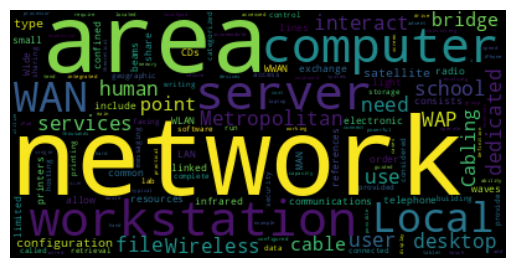

Frequent Words
dict_keys(['network', 'consists', 'computers', 'linked', 'order', 'share', 'resources', 'printers', 'CDs', 'exchange', 'files', 'allow', 'electronic', 'communications', 'cables', 'telephone', 'lines', 'radio', 'waves', 'satellites', 'infrared', 'light', 'beams', 'common', 'types', 'networks', 'include', 'Local', 'Area', 'Network', 'LAN', 'Wide', 'WAN', 'references', 'Metropolitan', 'Networks', 'MAN', 'Wireless', 'WLAN', 'WWAN', 'confined', 'small', 'area', 'limited', 'geographic', 'writing', 'lab', 'school', 'building', 'Computers', 'connected', 'categorized', 'servers', 'workstations', 'Servers', 'humans', 'run', 'provide', 'services', 'human', 'users', 'Services', 'provided', 'printing', 'faxing', 'software', 'hosting', 'file', 'storage', 'sharing', 'messaging', 'data', 'retrieval', 'complete', 'access', 'control', 'security', 'Workstations', 'called', 'user', 'interacts', 'considered', 'desktop', 'consisting', 'computer', 'keyboard', 'display', 'mouse', 'laptop', 'int

In [61]:
article_sample='''
A network consists of two or more computers that are linked in order to share resources (such as printers and CDs), exchange files, or allow electronic communications. The computers on a network may be linked through cables, telephone lines, radio waves, satellites, or infrared light beams.
Two very common types of networks include:
Local Area Network (LAN)
Wide Area Network (WAN)
You may also see references to a Metropolitan Area Networks (MAN), a Wireless LAN (WLAN), or a Wireless WAN (WWAN).
Local Area Network
A Local Area Network (LAN) is a network that is confined to a relatively small area. It is generally limited to a geographic area such as a writing lab, school, or building.
Computers connected to a network are broadly categorized as servers or workstations. Servers are generally not used by humans directly, but rather run continuously to provide "services" to the other computers (and their human users) on the network. Services provided can include printing and faxing, software hosting, file storage and sharing, messaging, data storage and retrieval, complete access control (security) for the network's resources, and many others.
Workstations are called such because they typically do have a human user which interacts with the network through them. Workstations were traditionally considered a desktop, consisting of a computer, keyboard, display, and mouse, or a laptop, with with integrated keyboard, display, and touchpad. With the advent of the tablet computer, and the touch screen devices such as iPad and iPhone, our definition of workstation is quickly evolving to include those devices, because of their ability to interact with the network and utilize network services.
Servers tend to be more powerful than workstations, although configurations are guided by needs. For example, a group of servers might be located in a secure area, away from humans, and only accessed through the network. In such cases, it would be common for the servers to operate without a dedicated display or keyboard. However, the size and speed of the server's processor(s), hard drive, and main memory might add dramatically to the cost of the system. On the other hand, a workstation might not need as much storage or working memory, but might require an expensive display to accommodate the needs of its user. Every computer on a network should be appropriately configured for its use.
On a single LAN, computers and servers may be connected by cables or wirelessly. Wireless access to a wired network is made possible by wireless access points (WAPs). These WAP devices provide a bridge between computers and networks. A typical WAP might have the theoretical capacity to connect hundreds or even thousands of wireless users to a network, although practical capacity might be far less.
Nearly always servers will be connected by cables to the network, because the cable connections remain the fastest. Workstations which are stationary (desktops) are also usually connected by a cable to the network, although the cost of wireless adapters has dropped to the point that, when installing workstations in an existing facility with inadequate wiring, it can be easier and less expensive to use wireless for a desktop.
See the Topology, Cabling, and Hardware sections of this tutorial for more information on the configuration of a LAN.
Wide Area Network
Wide Area Networks (WANs) connect networks in larger geographic areas, such as Florida, the United States, or the world. Dedicated transoceanic cabling or satellite uplinks may be used to connect this type of global network.
Using a WAN, schools in Florida can communicate with places like Tokyo in a matter of seconds, without paying enormous phone bills. Two users a half-world apart with workstations equipped with microphones and a webcams might teleconference in real time. A WAN is complicated. It uses multiplexers, bridges, and routers to connect local and metropolitan networks to global communications networks like the Internet. To users, however, a WAN will not appear to be much different than a LAN.
'''
generate_topic(article_sample)

**Article related to : Education**

-------- Doc :  1 -------- Length of Doc :  595 --------
Len of keywords 244


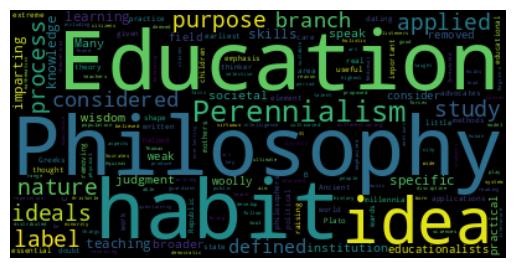

Frequent Words
dict_keys(['Philosophy', 'Education', 'label', 'applied', 'study', 'purpose', 'process', 'nature', 'ideals', 'education', 'considered', 'branch', 'philosophy', 'defined', 'teaching', 'learning', 'specific', 'skills', 'imparting', 'knowledge', 'judgment', 'wisdom', 'broader', 'societal', 'institution', 'speak', 'Many', 'educationalists', 'consider', 'weak', 'woolly', 'field', 'removed', 'practical', 'applications', 'real', 'world', 'useful', 'philosophers', 'dating', 'Plato', 'Ancient', 'Greeks', 'given', 'area', 'thought', 'emphasis', 'little', 'doubt', 'work', 'helped', 'shape', 'practice', 'millennia', 'earliest', 'important', 'educational', 'thinker', 'essential', 'element', 'Republic', 'political', 'theory', 'written', 'B.C.', 'advocates', 'extreme', 'methods', 'removing', 'children', 'mothers', 'care', 'raising', 'wards', 'state', 'differentiating', 'suitable', 'castes', 'highest', 'receiving', 'act', 'guardians', 'city', 'able', 'believed', 'holistic', 'including',

In [62]:
article_sample='''
Philosophy of Education is a label applied to the study of the purpose, process, nature and ideals of education. It can be considered a branch of both philosophy and education. Education can be defined as the teaching and learning of specific skills, and the imparting of knowledge, judgment and wisdom, and is something broader than the societal institution of education we often speak of.
Many educationalists consider it a weak and woolly field, too far removed from the practical applications of the real world to be useful. But philosophers dating back to Plato and the Ancient Greeks have given the area much thought and emphasis, and there is little doubt that their work has helped shape the practice of education over the millennia.
Plato is the earliest important educational thinker, and education is an essential element in "The Republic" (his most important work on philosophy and political theory, written around 360 B.C.). In it, he advocates some rather extreme methods: removing children from their mothers' care and raising them as wards of the state, and differentiating children suitable to the various castes, the highest receiving the most education, so that they could act as guardians of the city and care for the less able. He believed that education should be holistic, including facts, skills, physical discipline, music and art. Plato believed that talent and intelligence is not distributed genetically and thus is be found in children born to all classes, although his proposed system of selective public education for an educated minority of the population does not really follow a democratic model.
Aristotle considered human nature, habit and reason to be equally important forces to be cultivated in education, the ultimate aim of which should be to produce good and virtuous citizens. He proposed that teachers lead their students systematically, and that repetition be used as a key tool to develop good habits, unlike Socrates' emphasis on questioning his listeners to bring out their own ideas. He emphasized the balancing of the theoretical and practical aspects of subjects taught, among which he explicitly mentions reading, writing, mathematics, music, physical education, literature, history, and a wide range of sciences, as well as play, which he also considered important.
During the Medieval period, the idea of Perennialism was first formulated by St. Thomas Aquinas in his work "De Magistro". Perennialism holds that one should teach those things deemed to be of everlasting importance to all people everywhere, namely principles and reasoning, not just facts (which are apt to change over time), and that one should teach first about people, not machines or techniques. It was originally religious in nature, and it was only much later that a theory of secular perennialism developed.
During the Renaissance, the French skeptic Michel de Montaigne (1533 - 1592) was one of the first to critically look at education. Unusually for his time, Montaigne was willing to question the conventional wisdom of the period, calling into question the whole edifice of the educational system, and the implicit assumption that university-educated philosophers were necessarily wiser than uneducated farm workers, for example.
'''
generate_topic(article_sample)

**Article related to : A Greedy Dog (story)**

-------- Doc :  1 -------- Length of Doc :  117 --------
Len of keywords 39


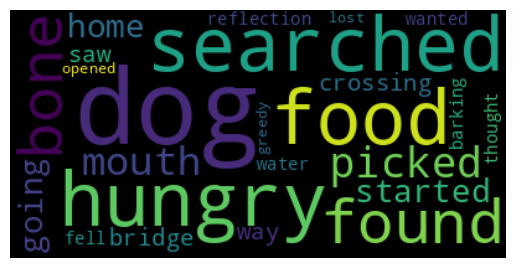

Frequent Words
dict_keys(['dog', 'hungry', 'searched', 'food', 'found', 'bone', 'picked', 'mouth', 'started', 'going', 'home', 'bridge', 'way', 'crossing', 'saw', 'reflection', 'water', 'thought', 'wanted', 'barking', 'fell', 'opened', 'greedy', 'lost'])
########## Possible Keywords Extracted ##########
{'possible_k': [['dog', 'NOUN', 'compound'], ['bone', 'NOUN', 'ROOT']], 'possible_s': 'dog bone'}
[['dog', 'NOUN', 'compound'], ['bone', 'NOUN', 'ROOT']]
########## TOPIC ANALYSIS ##########
START APPEND_A
dog KEEP
bone APPEND_.
########## FINAL TOPIC ##########
*** START A dog bone  END***


In [63]:
article_sample='''
There was a dog that was very hungry. He searched for food everywhere and at last he found a bone. He picked the bone with his mouth and started going back to his home. There was a bridge on the way to his home.
When he started crossing it he saw his reflection in the water. The dog thought that there was another dog with a bone in water. He wanted to get that other bone too.
So he started barking at his own reflection. His bone fell in water as soon as he opened his mouth. The greedy dog lost his bone.
'''
generate_topic(article_sample)

**Article related to : Responsibility (a moral story)**

-------- Doc :  1 -------- Length of Doc :  224 --------
Len of keywords 63


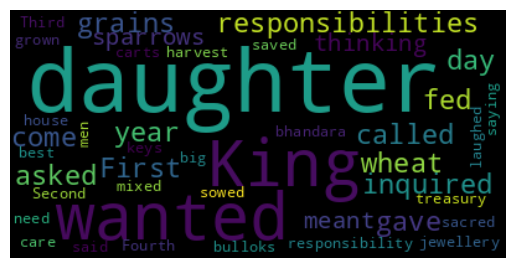

Frequent Words
dict_keys(['King', 'daughters', 'wanted', 'responsibilities', 'gave', 'wheat', 'grains', 'asked', 'come', 'year', 'called', 'inquired', 'First', 'daughter', 'day', 'fed', 'sparrows', 'thinking', 'meant', 'responsibility', 'Second', 'mixed', 'bhandara', 'sacred', 'care', 'Third', 'saved', 'jewellery', 'treasury', 'Fourth', 'need', 'bulloks', 'men', 'laughed', 'said', 'sowed', 'grown', 'big', 'harvest', 'carts', 'best', 'house', 'saying', 'keys'])
########## Possible Keywords Extracted ##########
{'possible_k': [['King', 'NOUN', 'compound'], ['wheat', 'NOUN', 'compound'], ['daughter', 'NOUN', 'compound'], ['care', 'NOUN', 'ROOT']], 'possible_s': 'King wheat daughter care'}
[['King', 'NOUN', 'compound'], ['wheat', 'NOUN', 'compound'], ['daughter', 'NOUN', 'compound'], ['care', 'NOUN', 'ROOT']]
########## TOPIC ANALYSIS ##########
START KEEP
King KEEP
wheat REPLACE_'s
daughter KEEP
care APPEND_.
########## FINAL TOPIC ##########
*** START King 's daughter care  END***


In [64]:
article_sample = '''
A King had four daughters, he wanted to see what responsibilities he can give to them. So he gave some wheat grains to each one of them and asked them to come back after an year.
After an year he called all the four daughters and inquired about the wheat.
First daughter : On the same day I fed it to sparrows thinking that they were meant for that. King did not give any responsibility to her.
Second daughter : I mixed them in the bhandara thinking that they are sacred and so that everyone could have it.
King : Ok you take care of bhandara.
Third daughter: I saved them safely along with my jewellery and here they are.
King : OK you take care of the treasury
Fourth daughter: I need two bulloks and two men to get the wheat.
All of them laughed and asked why ? So she said, "I sowed the grains and now its grown so big that I need to harvest it and get it on carts.
King : Good you are the best. You take care of the whole house and so saying he gave her the keys.
'''
generate_topic(article_sample)